In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact

import numpy as np


from scipy.interpolate import interp1d
# from dtaidistance import dtw
from scipy.stats import pearsonr

from scipy import spatial
import itertools

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN


In [2]:
raw_df = pd.read_csv("imdb_top_250_series_episode_ratings.csv")

raw_df.head()

,id,type,season,episode,titleText,releaseYear,plot,aggregateRating,voteCount,canRate,...,releaseDate.day,releaseDate.year,releaseDate.__typename,image.url,image.maxHeight,image.maxWidth,image.caption,title,series.id,releaseDate
0,tt0959621,tvEpisode,1,1,Pilot,2008.0,"Diagnosed with terminal lung cancer, chemistry...",9.0,44315,True,...,20.0,2008.0,ReleaseDate,https://m.media-amazon.com/images/M/MV5BNWRjMj...,1814,3224,Bryan Cranston in Pilot (2008),Breaking Bad,tt0903747,NaN
1,tt1054724,tvEpisode,1,2,Cat's in the Bag...,2008.0,After their first drug deal goes terribly wron...,8.6,32318,True,...,27.0,2008.0,ReleaseDate,https://m.media-amazon.com/images/M/MV5BNmI5MT...,705,940,Aaron Paul in Breaking Bad (2008),Breaking Bad,tt0903747,NaN
2,tt1054725,tvEpisode,1,3,...And the Bag's in the River,2008.0,Walt and Jesse clean up after the bathtub inci...,8.7,31307,True,...,10.0,2008.0,ReleaseDate,https://m.media-amazon.com/images/M/MV5BMjI4Nj...,375,500,Bryan Cranston and Aaron Paul in Breaking Bad ...,Breaking Bad,tt0903747,NaN
3,tt1054726,tvEpisode,1,4,Cancer Man,2008.0,Walt tells the rest of his family about his ca...,8.2,30119,True,...,17.0,2008.0,ReleaseDate,https://m.media-amazon.com/images/M/MV5BM2ExYj...,1333,1864,Bryan Cranston and Anna Gunn in Breaking Bad (...,Breaking Bad,tt0903747,NaN
4,tt1054727,tvEpisode,1,5,Gray Matter,2008.0,Walt rejects everyone who tries to help him wi...,8.3,29611,True,...,24.0,2008.0,ReleaseDate,https://m.media-amazon.com/images/M/MV5BNTgwOT...,1080,1920,Bryan Cranston and Anna Gunn in Breaking Bad (...,Breaking Bad,tt0903747,NaN


In [42]:
raw_df['releaseDate.year'].value_counts().sort_index()

releaseDate.year
1959.0     12
1960.0     47
1961.0     59
1962.0     36
1963.0     31
         ... 
2021.0    503
2022.0    573
2023.0    477
2024.0    258
2025.0     12
Name: count, Length: 63, dtype: int64

In [50]:
raw_df.groupby('title')['releaseDate.year'].max().sort_values().head(50)

title
The Twilight Zone                      1964.0
The Bugs Bunny Show                    1972.0
The World at War                       1974.0
I, Claudius                            1976.0
Fawlty Towers                          1979.0
Cosmos                                 1980.0
Yes Minister                           1984.0
The Adventures of Sherlock Holmes      1985.0
Blackadder II                          1986.0
Blackadder the Third                   1987.0
Ramayan                                1988.0
The Return of Sherlock Holmes          1988.0
Yes, Prime Minister                    1988.0
Lonesome Dove                          1989.0
Mahabharat                             1989.0
Blackadder Goes Forth                  1989.0
Dekalog                                1990.0
The Civil War                          1990.0
Star Trek: The Next Generation         1994.0
Batman: The Animated Series            1995.0
Mr. Bean                               1995.0
Pride and Prejudice         

['Batman: The Animated Series',
 'Blackadder Goes Forth',
 'Blackadder II',
 'Blackadder the Third',
 'Cosmos',
 'Das Boot',
 'Dekalog',
 'Fawlty Towers',
 'I, Claudius',
 'Lonesome Dove',
 'Mahabharat',
 'Mr. Bean',
 'Pride and Prejudice',
 'Ramayan',
 'Star Trek: The Next Generation',
 'The Adventures of Sherlock Holmes',
 'The Bugs Bunny Show',
 'The Civil War',
 'The Return of Sherlock Holmes',
 'The Twilight Zone',
 'The World at War',
 'Yes Minister',
 'Yes, Prime Minister']

In [55]:
df = raw_df.loc[(raw_df['season'] != 'Unknown') & (raw_df['episode'] != '0')] # drop any special eps or upcoming eps

df = df[['title', 'series.id', 'titleText', 'id', 'season', 'episode', 'aggregateRating']].copy() # filter on desired columns

df['season'] = df['season'].astype(int)
df['episode'] = df['episode'].astype(int)

df = df.dropna(subset=["aggregateRating"]) # some specials or yet unreleased episodes have na for their rating

tv_last_release_year = raw_df.groupby('title')['releaseDate.year'].max()
min_year_list = tv_last_release_year[tv_last_release_year >= 1997].index.tolist()
df = df.loc[df['title'].isin(min_year_list)].copy()

df.head()

,title,series.id,titleText,id,season,episode,aggregateRating
0,Breaking Bad,tt0903747,Pilot,tt0959621,1,1,9.0
1,Breaking Bad,tt0903747,Cat's in the Bag...,tt1054724,1,2,8.6
2,Breaking Bad,tt0903747,...And the Bag's in the River,tt1054725,1,3,8.7
3,Breaking Bad,tt0903747,Cancer Man,tt1054726,1,4,8.2
4,Breaking Bad,tt0903747,Gray Matter,tt1054727,1,5,8.3


# Highest and lowest ranked episode and season per series

In [56]:
tv_highest_rated_ep = df.groupby('title')['aggregateRating'].max().sort_values(ascending=False)

tv_highest_rated_ep.head(10)

title
Breaking Bad                           10.0
Avatar: The Last Airbender              9.9
Better Call Saul                        9.9
Bluey                                   9.9
Behzat Ç: An Ankara Detective Story     9.9
BoJack Horseman                         9.9
Game of Thrones                         9.9
Gravity Falls                           9.9
Demon Slayer: Kimetsu no Yaiba          9.9
Mr. Robot                               9.9
Name: aggregateRating, dtype: float64

In [57]:
df.loc[df['aggregateRating']==10]

,title,series.id,titleText,id,season,episode,aggregateRating
59,Breaking Bad,tt0903747,Ozymandias,tt2301451,5,14,10.0


In [58]:
tv_lowest_rated_ep = df.groupby('title')['aggregateRating'].min().sort_values()

tv_lowest_rated_ep.tail(5)

title
Planet Earth II          8.7
The Last Dance           8.8
The Beatles: Get Back    8.9
Chernobyl                9.3
Sapne Vs Everyone        9.5
Name: aggregateRating, dtype: float64

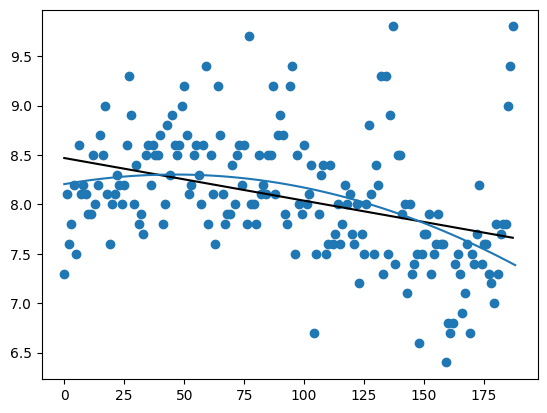

-0.0043139241512207775
            2
-4.558e-05 x + 0.00421 x + 8.205


In [59]:
y = df.loc[df['series.id']=="tt0386676"].sort_values(by=['season', 'episode']).reset_index(drop=True).aggregateRating.values
x = np.arange(0,len(y))

#Fit line
slope, intercept = np.polyfit(x, y, 1)

#Plot
plt.figure()
plt.scatter(x, y) 
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'k')

model = np.poly1d(np.polyfit(x, y, 2))
polyline = np.linspace(0, len(x), 100)
plt.plot(polyline, model(polyline))

plt.show()

print(slope)
print(model)

In [60]:
df.loc[(df['series.id']=='tt0052520')]

,title,series.id,titleText,id,season,episode,aggregateRating


In [61]:
df['series.id'].value_counts().head(50)

series.id
tt0096697    767
tt0380136    339
tt0121955    321
tt3530232    306
tt0229889    304
tt0214341    276
tt1305826    276
tt2100976    254
tt1710308    244
tt1628033    241
tt0108778    234
tt0163507    219
tt0106179    217
tt0988818    214
tt0094517    197
tt0421291    190
tt0386676    188
tt0412142    176
tt0098904    173
tt0472954    169
tt0200276    155
tt0436992    154
tt0280249    153
tt4934214    152
tt7678620    150
tt0149460    150
tt4834232    150
tt1831164    144
tt1486217    143
tt1586680    134
tt1266020    124
tt0106028    122
tt0264235    120
tt1439629    110
tt5555260    106
tt0290988    106
tt1795096    105
tt2433738    100
tt1641384     98
tt0773262     96
tt1124373     92
tt0804503     92
tt2560140     89
tt0286486     88
tt0141842     86
tt3398540     85
tt0367279     84
tt0417373     83
tt4647692     80
tt3526078     80
Name: count, dtype: int64

In [62]:
def heatmap_tv_series(series_name):
    
    if series_name == 'The Office':
        tv = df.loc[(df['series.id']=='tt0386676')].copy()
    else:
        tv = df.loc[(df['title']==series_name)].copy()
    tv_pivot = tv.pivot(index='season', 
                           columns='episode',
                          values='aggregateRating')
    
    fig, ax = plt.subplots(1,1, figsize=(20, 7))
    sns.heatmap(tv_pivot, 
                annot=True, 
                cbar=False,
                cmap="RdYlGn",
               center=7,
               linewidths=0.07,
               square=False,
               annot_kws={"size": 12})  

    ax.axes.set_title("",fontsize=20)
    ax.set_xlabel("Episode",fontsize=15)
    ax.set_ylabel("Season",fontsize=15)
#     ax.set_title(f"Heatmap of IMDb episode ratings for {series_name}",fontsize=30)

    ax.tick_params(left=False, bottom=False)
    
    plt.yticks(rotation = 0, fontsize='large')
    plt.xticks(fontsize='large')

    plt.show()
    
dropdown_list_order = df.title.sort_values().unique().tolist()
n_widget = widgets.Dropdown(options=df.title.sort_values().unique().tolist(), value='Top Gear', description='TV Series')

widgets.interact(heatmap_tv_series, series_name=n_widget);

interactive(children=(Dropdown(description='TV Series', index=206, options=('1883', 'Adventure Time', 'Africa'…

In [63]:
df.loc[df['title'].isin(["Breaking Bad", "Game of Thrones"])].groupby(['title','season'])['aggregateRating'].mean().reset_index()

,title,season,aggregateRating
0,Breaking Bad,1,8.700000
1,Breaking Bad,2,8.776923
2,Breaking Bad,3,8.746154
3,Breaking Bad,4,8.969231
4,Breaking Bad,5,9.387500
5,Game of Thrones,1,8.970000
6,Game of Thrones,2,8.810000
7,Game of Thrones,3,8.940000
8,Game of Thrones,4,9.230000
9,Game of Thrones,5,8.700000


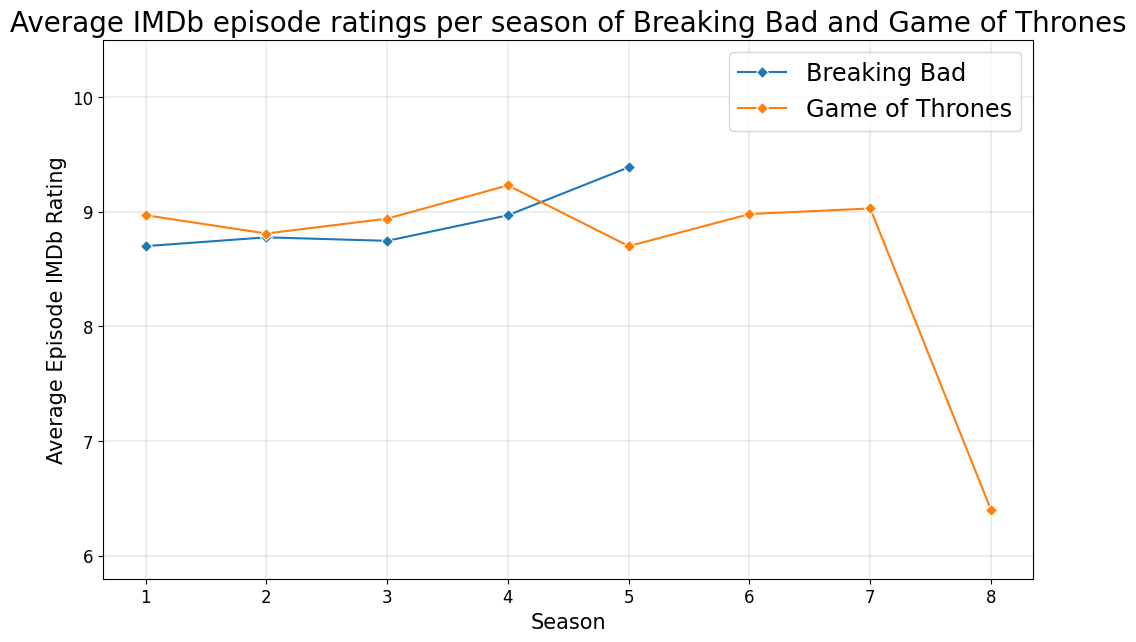

In [64]:
data_for_plot = df.loc[df['title'].isin(["Breaking Bad", "Game of Thrones"])].groupby(['title','season'])['aggregateRating'].mean().reset_index()

fig, ax = plt.subplots(1,1, figsize=(12, 7))

sns.lineplot(x="season",
             y="aggregateRating",
            hue="title",
            data=data_for_plot,
             marker='D'
          )
           
plt.ylim(5.8, 10.5)  # Set the y-axis limits from 0 to 8

ax.axes.set_title("Average IMDb episode ratings per season of Breaking Bad and Game of Thrones",fontsize=20)
ax.set_xlabel("Season",fontsize=15)
ax.set_ylabel("Average Episode IMDb Rating",fontsize=15)

ax.yaxis.set_tick_params(labelsize = 12)
ax.xaxis.set_tick_params(labelsize = 12)

plt.grid(True, color='black', linewidth=.1)

plt.legend(fontsize='xx-large')

plt.show()

# Clustering

In [65]:
top_season_avg_df = df.groupby(['series.id', 'season'])['aggregateRating'].mean().reset_index().groupby('series.id')['aggregateRating'].max().reset_index().rename(columns={'aggregateRating': 'top_season_avg'})
top_season_avg_df.set_index('series.id', inplace=True)
top_season_avg_df

,top_season_avg
series.id,
tt0063929,8.107692
tt0081912,9.200000
tt0088509,7.356000
tt0094517,7.858333
tt0094525,8.025000
...,...
tt9253866,8.975000
tt9335498,8.722222
tt9432978,8.700000


In [66]:
bottom_season_avg_df = df.groupby(['series.id', 'season'])['aggregateRating'].mean().reset_index().groupby('series.id')['aggregateRating'].min().reset_index().rename(columns={'aggregateRating': 'bottom_season_avg'})
bottom_season_avg_df.set_index('series.id', inplace=True)
bottom_season_avg_df

,bottom_season_avg
series.id,
tt0063929,7.366667
tt0081912,7.733333
tt0088509,7.356000
tt0094517,6.685714
tt0094525,7.300000
...,...
tt9253866,8.650000
tt9335498,7.900000
tt9432978,8.600000


In [67]:
all_eps_avg_df = df.groupby(['series.id'])['aggregateRating'].mean().reset_index().groupby('series.id')['aggregateRating'].max().reset_index().rename(columns={'aggregateRating': 'all_eps_avg'})
all_eps_avg_df.set_index('series.id', inplace=True)
all_eps_avg_df

,all_eps_avg
series.id,
tt0063929,7.928889
tt0081912,8.312698
tt0088509,7.356000
tt0094517,7.569036
tt0094525,7.642857
...,...
tt9253866,8.866667
tt9335498,8.404762
tt9432978,8.640000


In [68]:
highest_rated_ep_df = df.groupby(['series.id'])['aggregateRating'].max().reset_index().rename(columns={'aggregateRating': 'highest_rated_ep'})
highest_rated_ep_df.set_index('series.id', inplace=True)
highest_rated_ep_df

,highest_rated_ep
series.id,
tt0063929,8.9
tt0081912,9.6
tt0088509,7.9
tt0094517,9.0
tt0094525,8.5
...,...
tt9253866,9.2
tt9335498,9.9
tt9432978,9.4


In [69]:
lowest_rated_ep_df = df.groupby(['series.id'])['aggregateRating'].min().reset_index().rename(columns={'aggregateRating': 'lowest_rated_ep'})
lowest_rated_ep_df.set_index('series.id', inplace=True)
lowest_rated_ep_df

,lowest_rated_ep
series.id,
tt0063929,7.2
tt0081912,7.1
tt0088509,6.8
tt0094517,6.3
tt0094525,6.9
...,...
tt9253866,8.6
tt9335498,7.1
tt9432978,8.1


In [70]:
n_seasons_df = df.groupby(['series.id'])['season'].max().reset_index().rename(columns={'season': 'n_seasons'})
n_seasons_df.set_index('series.id', inplace=True)
n_seasons_df.sort_values(by='n_seasons')

,n_seasons
series.id,
tt0088509,1
tt0112159,1
tt0120570,1
tt0118273,1
tt0193676,1
...,...
tt4934214,17
tt0380136,21
tt0121955,26


In [71]:
n_episodes_df = df.groupby(['series.id'])['episode'].count().reset_index().rename(columns={'episode': 'n_episodes'})
n_episodes_df.set_index('series.id', inplace=True)
n_episodes_df.sort_values(by='n_episodes')

,n_episodes
series.id,
tt0314979,2
tt9735318,3
tt0417349,4
tt0203082,4
tt7137906,4
...,...
tt0229889,304
tt3530232,306
tt0121955,321


In [72]:
data_list = []

for s_id in df['series.id'].unique():
    
    # y = df.loc[df['title']==title].sort_values(by=['season', 'episode']).reset_index(drop=True).aggregateRating.values
    
#     w=3
#     y = df.loc[df['title']==title].sort_values(by=['season', 'episode']).reset_index(drop=True).aggregateRating.rolling(window=w).mean().values[w-1:]
    y = df.loc[df['series.id']==s_id].sort_values(by=['season', 'episode']).reset_index(drop=True).aggregateRating.values

    x = np.arange(0,len(y))

    model = np.poly1d(np.polyfit(x, y, 1))
    coefs = model.coefficients
    
    data_list.append({'series.id': s_id,
                     'trend_slope': coefs[0]
#                      'constant_1': coefs[1]
                     })

del(x)
del(y)

series_slope_df = pd.DataFrame(data_list)
series_slope_df.set_index('series.id', inplace=True)
series_slope_df.head()

,trend_slope
series.id,
tt0903747,0.016366
tt5491994,-0.094286
tt0795176,-0.005455
tt0185906,0.053939
tt7366338,0.050000


In [73]:
cluster_df = pd.concat([top_season_avg_df, bottom_season_avg_df, all_eps_avg_df, 
                        series_slope_df,
                       highest_rated_ep_df, lowest_rated_ep_df,
                       n_seasons_df, n_episodes_df], axis=1)
# cluster_df['series_id'] = cluster_df.index

cluster_df.reset_index(drop=False, inplace=True)

# id to title lookup
temp = df[['series.id', 'title']].drop_duplicates().copy().reset_index(drop=True)
title_keys = temp['series.id'].values.tolist()
title_values = temp['title'].values.tolist()
id_title_lookup = dict(map(lambda i,j : (i,j) , title_keys, title_values))

cluster_df['title'] = cluster_df['series.id'].apply(lambda x: id_title_lookup[x])

cluster_df = cluster_df.loc[cluster_df['n_seasons'] >= 3]

cluster_df = cluster_df.loc[cluster_df['n_episodes'] <= 250]

cluster_df['top_bottom_season_gap'] = cluster_df['top_season_avg'] - cluster_df['bottom_season_avg']

cluster_df.sort_values(by='n_seasons')

,series.id,top_season_avg,bottom_season_avg,all_eps_avg,trend_slope,highest_rated_ep,lowest_rated_ep,n_seasons,n_episodes,title,top_bottom_season_gap
11,tt0111958,8.550000,7.916667,8.288000,0.027692,9.1,7.7,3,25,Father Ted,0.633333
46,tt0353049,8.137500,7.466667,7.939394,-0.006584,9.4,7.2,3,33,Chappelle's Show,0.670833
56,tt0417299,8.871429,8.220000,8.595082,0.019958,9.9,6.8,3,61,Avatar: The Last Airbender,0.651429
37,tt0290978,8.900000,8.050000,8.314286,0.079560,9.3,7.6,3,14,The Office,0.850000
45,tt0348914,8.341667,8.291667,8.319444,0.005109,9.1,7.9,3,36,Deadwood,0.050000
...,...,...,...,...,...,...,...,...,...,...,...
4,tt0094525,8.025000,7.300000,7.642857,0.008223,8.5,6.9,13,70,Poirot,0.725000
110,tt1486217,8.150000,7.325000,7.888811,-0.003202,9.0,6.9,14,143,Archer,0.825000
65,tt0472954,8.583333,7.870000,8.363905,-0.002080,9.8,6.6,16,169,It's Always Sunny in Philadelphia,0.713333
187,tt4934214,8.310000,7.510000,7.905263,-0.002446,8.8,7.3,17,152,Taskmaster,0.800000


In [74]:
cluster_df.columns

Index(['series.id', 'top_season_avg', 'bottom_season_avg', 'all_eps_avg',
       'trend_slope', 'highest_rated_ep', 'lowest_rated_ep', 'n_seasons',
       'n_episodes', 'title', 'top_bottom_season_gap'],
      dtype='object')

In [75]:
cluster_cols = ['top_season_avg', 'bottom_season_avg', 'top_bottom_season_gap',
                'all_eps_avg', #'n_seasons',
               'trend_slope', 'highest_rated_ep', 'lowest_rated_ep']

X = cluster_df[cluster_cols]

# standardize data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=4)
pca.fit(X_std)
X_pca = pca.transform(X_std)

print(sum(pca.explained_variance_ratio_))

0.9683503175630782


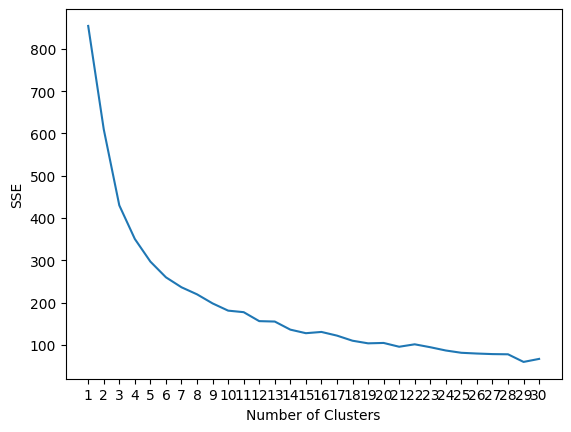

In [76]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
top_k = 30
for k in range(1, top_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, top_k+1), sse)
plt.xticks(range(1, top_k+1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

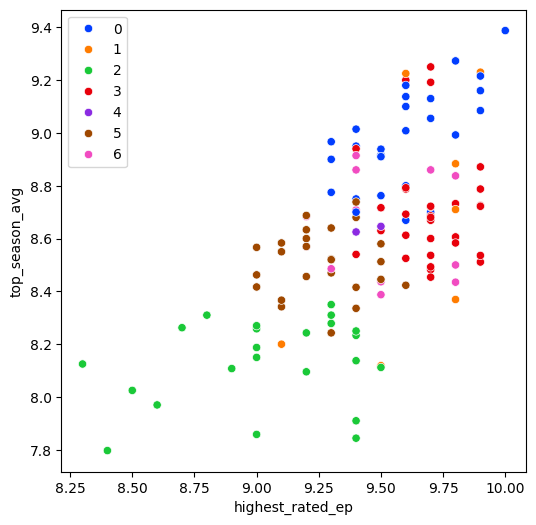

In [86]:


# pca = PCA(n_components=4)
# pca.fit(X_std)
# X_pca = pca.transform(X_std)


# kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(X_pca)
# labels = kmeans.labels_


hier = AgglomerativeClustering(n_clusters=7).fit(X_pca)
labels = hier.labels_


cluster_df['labels'] = labels

plt.figure(figsize=(6,6))
sns.scatterplot(x=cluster_df['highest_rated_ep'], 
                y=cluster_df['top_season_avg'], 
                hue=labels,
                palette='bright')

plt.show()

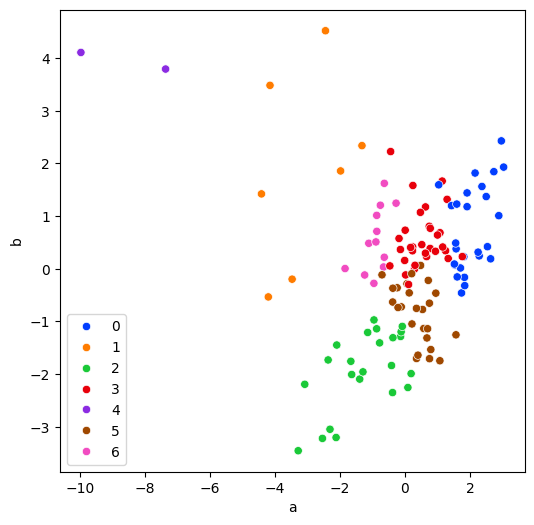

In [87]:
pca_df = pd.DataFrame(X_pca, columns=['a', 'b', 'c', 'd'])

plt.figure(figsize=(6,6))
sns.scatterplot(x=pca_df['a'], 
                y=pca_df['b'], 
                hue=labels,
               palette='bright')
plt.show()

In [88]:
cluster_df['labels'].value_counts().sort_index()

labels
0    26
1     7
2    23
3    31
4     2
5    25
6    12
Name: count, dtype: int64

In [89]:
cluster_df.groupby('labels')[cluster_cols].mean().round(3)

,top_season_avg,bottom_season_avg,top_bottom_season_gap,all_eps_avg,trend_slope,highest_rated_ep,lowest_rated_ep
labels,,,,,,,
0,8.980,8.484,0.496,8.717,0.014,9.596,7.869
1,8.677,6.763,1.914,8.055,-0.030,9.643,4.643
2,8.134,7.578,0.556,7.903,-0.001,9.043,6.970
3,8.710,8.041,0.668,8.380,0.005,9.697,7.048
4,8.636,3.400,5.236,7.707,-0.023,9.450,2.400
5,8.510,8.014,0.496,8.283,0.007,9.264,7.580
6,8.640,7.491,1.148,8.242,-0.015,9.500,6.758


In [105]:
cluster_df.loc[cluster_df['labels'].isin([6])].sort_values(by=['labels', 'title'], ascending=[True, True])

,series.id,top_season_avg,bottom_season_avg,all_eps_avg,trend_slope,highest_rated_ep,lowest_rated_ep,n_seasons,n_episodes,title,top_bottom_season_gap,labels
47,tt0367279,8.569231,7.125000,8.054762,-0.016529,9.2,6.6,5,84,Arrested Development,1.444231,6
106,tt1439629,8.500000,7.384615,8.181818,-0.003657,9.8,6.6,6,110,Community,1.115385,6
30,tt0237123,8.683333,7.666667,8.421429,-0.033881,9.2,7.3,4,28,Coupling,1.016667,6
159,tt2802850,8.860000,7.400000,8.331373,-0.023846,9.4,7.1,5,51,Fargo,1.460000,6
183,tt4647692,8.485714,7.600000,8.172500,-0.003181,9.3,6.4,12,80,Letterkenny,0.885714,6
97,tt1266020,8.387500,7.150000,8.069355,0.002514,9.5,6.9,7,124,Parks and Recreation,1.237500,6
6,tt0098904,8.436364,7.400000,8.274566,0.002126,9.5,6.9,9,173,Seinfeld,1.036364,6
120,tt1586680,8.708333,7.483333,8.230597,-0.007167,9.4,6.6,11,134,Shameless,1.225000,6
215,tt8111088,8.837500,7.737500,8.345833,-0.028391,9.8,6.4,3,24,The Mandalorian,1.100000,6
50,tt0386676,8.434783,7.404167,8.065426,-0.004314,9.8,6.4,9,188,The Office,1.030616,6


20            Futurama
63          Doctor Who
69              Dexter
75     Game of Thrones
137       Black Mirror
149     True Detective
160     Rick and Morty
Name: title, dtype: object

# Declining ratings

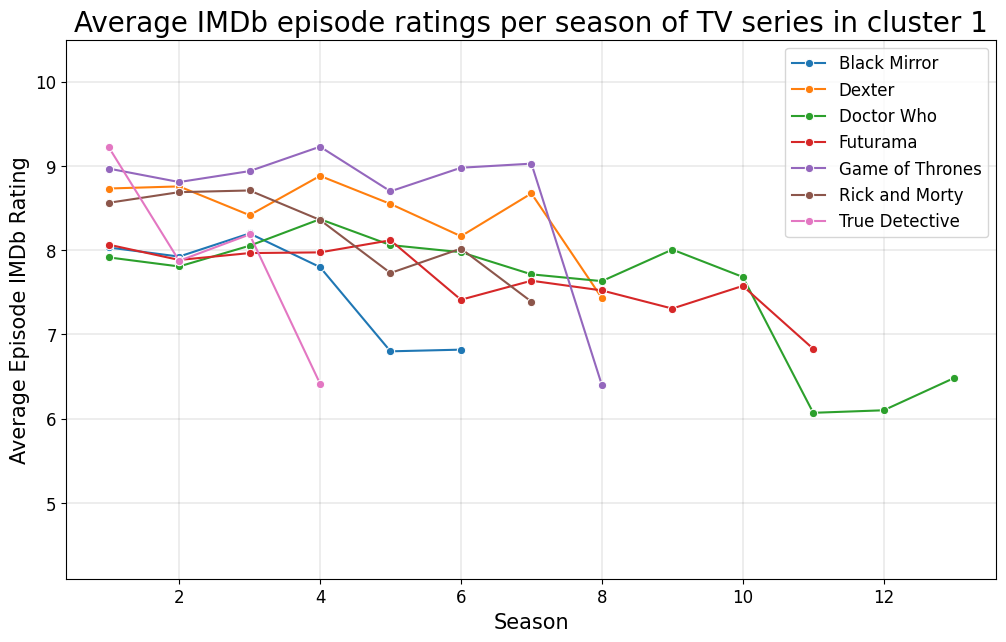

In [117]:
titles_for_plot = cluster_df.loc[cluster_df['labels']==1]['title'].values
data_for_plot = df.loc[df['title'].isin(titles_for_plot)].groupby(['title','season'])['aggregateRating'].mean().reset_index()

fig, ax = plt.subplots(1,1, figsize=(12, 7))

sns.lineplot(x="season",
             y="aggregateRating",
            hue="title",
            data=data_for_plot,
             marker='o'
          )
           
plt.ylim(4.1, 10.5)  # Set the y-axis limits from 0 to 8

ax.axes.set_title("Average IMDb episode ratings per season of TV series in cluster 1",fontsize=20)
ax.set_xlabel("Season",fontsize=15)
ax.set_ylabel("Average Episode IMDb Rating",fontsize=15)

ax.yaxis.set_tick_params(labelsize = 12)
ax.xaxis.set_tick_params(labelsize = 12)

plt.grid(True, color='black', linewidth=.1)

plt.legend(fontsize='large')

plt.show()

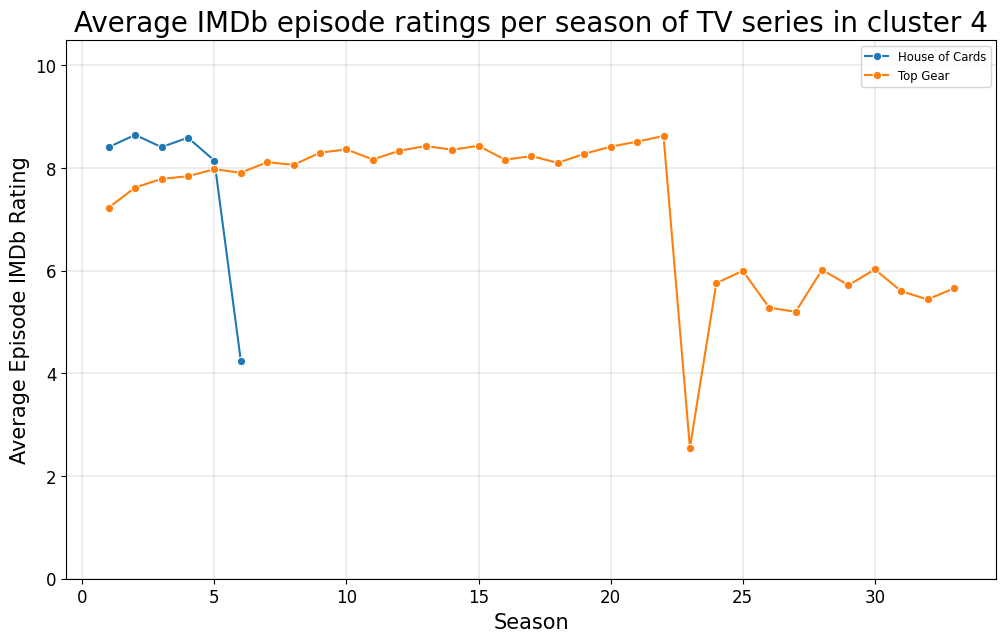

In [125]:
cluster_number = 4
titles_for_plot = cluster_df.loc[cluster_df['labels']==cluster_number]['title'].values
data_for_plot = df.loc[df['title'].isin(titles_for_plot)].groupby(['title','season'])['aggregateRating'].mean().reset_index()

fig, ax = plt.subplots(1,1, figsize=(12, 7))

sns.lineplot(x="season",
             y="aggregateRating",
            hue="title",
            data=data_for_plot,
             marker='o'
          )
           
plt.ylim(0, 10.5)  # Set the y-axis limits from 0 to 8

ax.axes.set_title(f"Average IMDb episode ratings per season of TV series in cluster {cluster_number}",fontsize=20)
ax.set_xlabel("Season",fontsize=15)
ax.set_ylabel("Average Episode IMDb Rating",fontsize=15)

ax.yaxis.set_tick_params(labelsize = 12)
ax.xaxis.set_tick_params(labelsize = 12)

plt.grid(True, color='black', linewidth=.1)

plt.legend(fontsize='small')

plt.show()

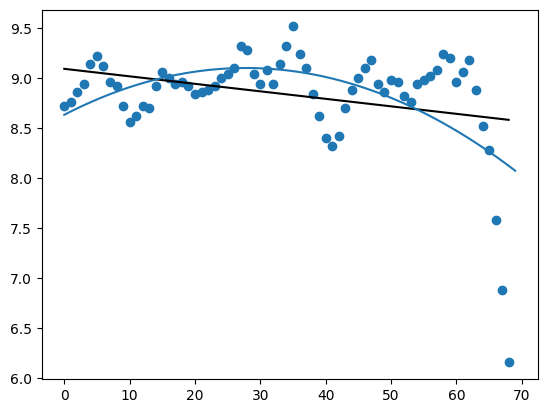

-0.007500913408841778
            2
-0.0006051 x + 0.03365 x + 8.637


In [165]:
w=5
y = df.loc[df['title']=='Game of Thrones'].sort_values(by=['season', 'episode']).reset_index(drop=True).aggregateRating.rolling(window=w).mean().values[w-1:]
x = np.arange(0,len(y))

#Fit line
slope, intercept = np.polyfit(x, y, 1)

#Plot
plt.figure()
plt.scatter(x, y) 
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'k')

model = np.poly1d(np.polyfit(x, y, 2))
polyline = np.linspace(0, len(x), 100)
plt.plot(polyline, model(polyline))

plt.show()

print(slope)
print(model)

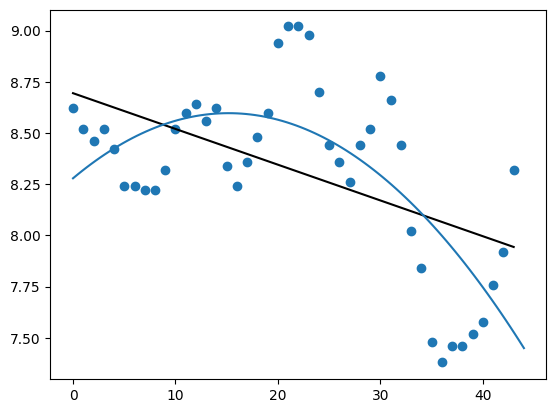

-0.017457364341085246
          2
-0.00138 x + 0.04189 x + 8.279


In [167]:
w=5
y = df.loc[df['title']=='Twin Peaks'].sort_values(by=['season', 'episode']).reset_index(drop=True).aggregateRating.rolling(window=w).mean().values[w-1:]
x = np.arange(0,len(y))

#Fit line
slope, intercept = np.polyfit(x, y, 1)

#Plot
plt.figure()
plt.scatter(x, y) 
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'k')

model = np.poly1d(np.polyfit(x, y, 2))
polyline = np.linspace(0, len(x), 100)
plt.plot(polyline, model(polyline))

plt.show()

print(slope)
print(model)